[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PyMPDATA/blob/main/examples/PyMPDATA_examples/burgers_equation/burgers_equation.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PyMPDATA.git/main?urlpath=lab/tree/examples/PyMPDATA_examples/burgers_equation/burgers_equation.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PyMPDATA/blob/main/examples/PyMPDATA_examples/burgers_equation/burgers_equation.ipynb)

Solution to the [Burgers' equation](https://en.wikipedia.org/wiki/Burgers%27_equation) using MPDATA compared against analytic results   
(based on students' project by: Wojciech Neuman, Paulina Pojda, Michał Szczygieł, Joanna Wójcicka & Antoni Zięciak)

$$ \partial_t u = -u\partial_x u = -\frac{1}{2} \partial_x u^2 $$

Initial and boundary conditions:
- $-1 \le x \le 1$
- $u(x, 0) = -\sin(\pi * x)$
- $u(-1, t) = u(1, t) = 0$

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PyMPDATA-examples')

In [2]:
import numpy as np
from functools import partial
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_anim
from scipy.optimize import root_scalar
from PyMPDATA import Options, ScalarField, Solver, Stepper, VectorField
from PyMPDATA.boundary_conditions import Constant

## Numerical solver

In [3]:
def interpolate_in_space_and_multiply(*, vector_out, scalar_in, multiplier):
    vector_out[:] = multiplier * (scalar_in[1:] + scalar_in[:-1]) / 2

def extrapolate_in_time(*, vectors_in, vector_out):
    vector_out[:] = 0.5 * (3 * vectors_in[0] - vectors_in[1])

def advector_view_no_edges(solver):
    return solver.advector.get_component(0)[1:-1]

def check_cfl_condition(solver):
    assert np.all(solver.advector.get_component(0) <= 1)

def run_numerical_simulation(*, nt, t_max, dx, psi0):
    dt = t_max / nt
    boundary_conditions = Constant(0),
    options = Options(nonoscillatory=True, infinite_gauge=True, n_iters=3)

    solver = Solver(
        stepper=Stepper(
            options=options,
            grid=psi0.shape
        ),
        advectee=ScalarField(
            data=psi0,
            halo=options.n_halo,
            boundary_conditions=boundary_conditions,
        ),
        advector=VectorField(
            data=(np.zeros(len(psi0)+1),),
            halo=options.n_halo,
            boundary_conditions=boundary_conditions,
        ),        
    )

    compute_advector = partial(
        interpolate_in_space_and_multiply,
        scalar_in=solver.advectee.get(),
        multiplier=.5 * dt / dx
    )
    
    interpolated_advectors = tuple(
        np.empty_like(advector_view_no_edges(solver))
        for _ in (0,1)
    )
    
    states = []
    compute_advector(vector_out=interpolated_advectors[1])
    for step in range(nt + 1):
        if step != 0:
            compute_advector(vector_out=interpolated_advectors[0])
            extrapolate_in_time(vector_out=advector_view_no_edges(solver), vectors_in=interpolated_advectors)
            check_cfl_condition(solver)
            solver.advance(n_steps=1)
            interpolated_advectors = interpolated_advectors[::-1]
        states.append(solver.advectee.get().copy())

    return states, x, dt

## Numerical solution

In [4]:
def initial_condition(x):
    return -np.sin(np.pi * x)

T_MAX = 1
NT = 400
NX = 100

x, dx = np.linspace(-1 + 1/NX, 1 - 1/NX, NX, retstep=True)
states_num, x_num, dt_num = run_numerical_simulation(
    nt=NT,
    t_max=T_MAX,
    dx=dx,
    psi0=initial_condition(x),
)

## Semi-analytic solver

In [7]:
function = lambda x, t, initial: x - np.sin(np.pi * x) * t - initial
fprime = lambda x, t, _: 1 - np.cos(np.pi * x) * np.pi * t
fprime2 = lambda x, t, _: np.sin(np.pi * x) * np.pi**2 * t

def analytical_solution(x, t): 
    u = np.zeros_like(x)
    for i, xi in enumerate(x):
        res = root_scalar(
            f=function,
            args=(t, xi),
            x0=xi / abs(xi),
            fprime=fprime,
            fprime2=fprime2,
            method='halley',
            maxiter=10000
        )   
        assert res.converged
        u[i] = initial_condition(res.root)
    return u

## Animation


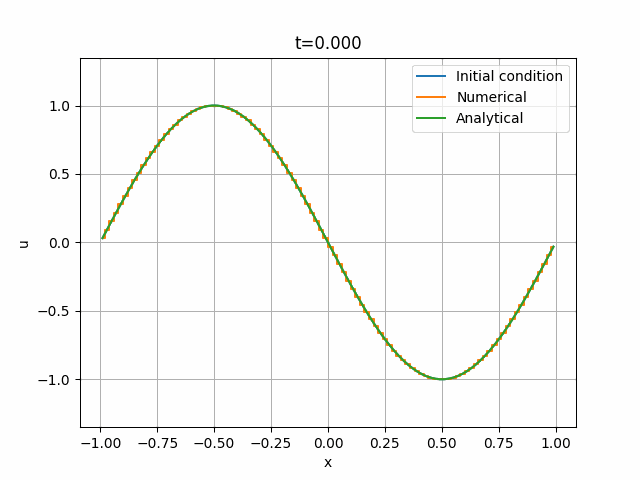

HTML(value="<a href='./burgers.gif' target='_blank'>./burgers.gif</a><br>")

In [10]:
def plot_gif(step, states, x, dt):
    fig, ax = pyplot.subplots()
    for t, y, label, style in [
        (0, analytical_solution(x, 0), "Initial condition", '-'),
        (step*dt, states[step], "Numerical", 'step'),
        (step*dt, analytical_solution(x, step*dt), "Analytical", '-')
    ]:
        if style == 'step':
            ax.step(x, y, where='mid', label=label)
        else:
            ax.plot(x, y, label=label)
    ax.set(xlabel="x", ylabel="u", ylim=(-1.35, 1.35), title=f"t={step*dt:.3f}")
    ax.grid();
    ax.legend()
    return fig

show_anim(partial(plot_gif, states=states_num, x=x_num, dt=dt_num), range(NT+1), gif_file="burgers.gif")